<a href="https://colab.research.google.com/github/lucky-verma/US-Driver-License-data-extraction/blob/master/Donut/CORD/Quick_inference_with_transformer_for_DL_Parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

First, we install 🤗 Transformers, Datasets and SentencePiece (the latter is used for tokenization).

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.2 MB/s eta 0:00:00


In [2]:
!pip install -q datasets sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.6 MB/s eta 0:00:00


## Load image

In [12]:
import cv2
import glob
import re
import torch

from PIL import Image

images = [Image.fromarray(np.uint8(cv2.imread(file))).convert('RGB') for file in glob.glob('./images/*.jpg')]

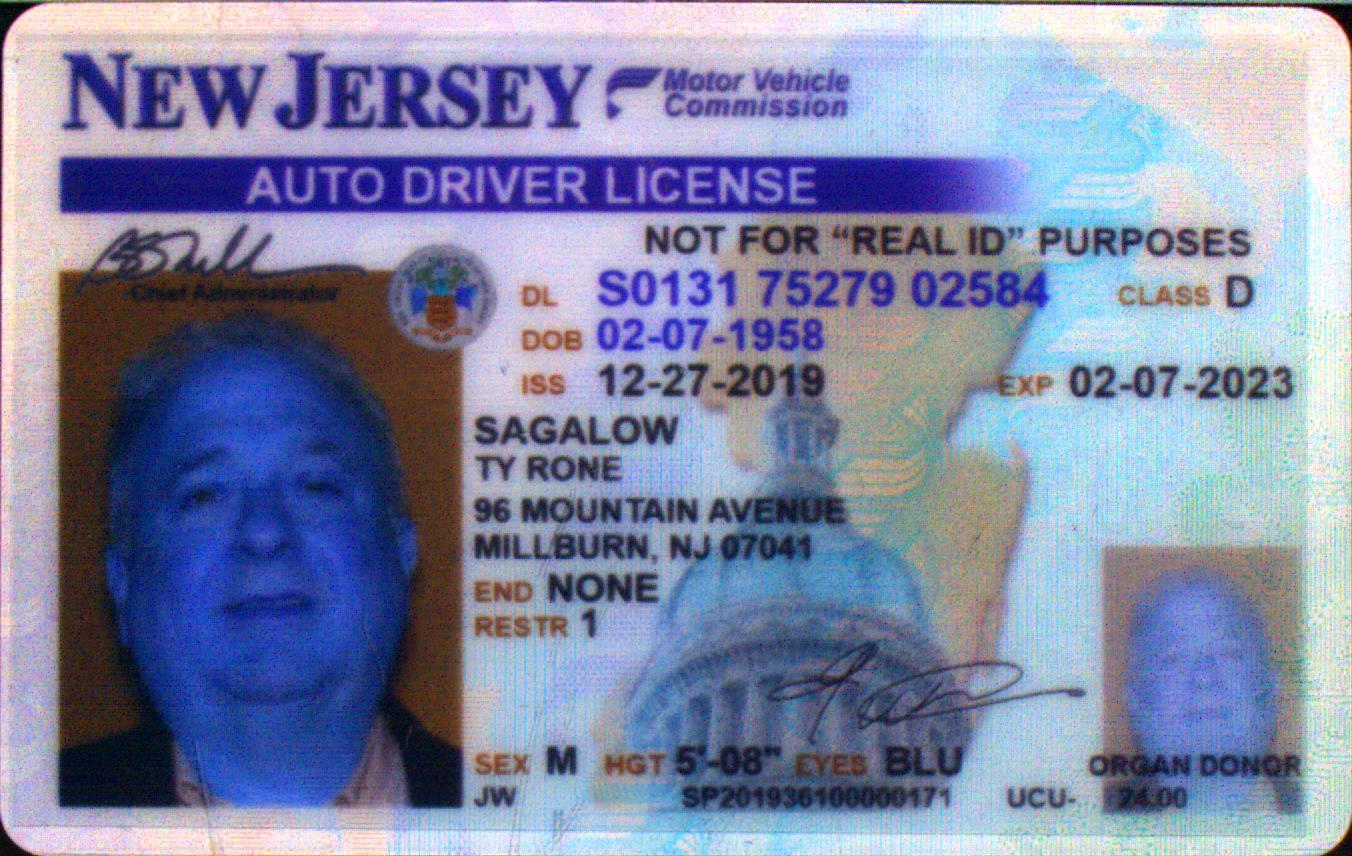

In [13]:
images[0]

## Load model and processor

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

In [14]:
processor = DonutProcessor.from_pretrained("thinkersloop/donut-demo")
model = VisionEncoderDecoderModel.from_pretrained("thinkersloop/donut-demo")

Downloading:   0%|          | 0.00/421 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/355 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/809M [00:00<?, ?B/s]

## Generate

Finally, we let the model autoregressively generate the structured data.

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


for idx, image in enumerate(images):
  pixel_values = processor(image, return_tensors="pt").pixel_values

  task_prompt = "<s_cord-v2>"
  decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

  outputs = model.generate(pixel_values.to(device),
                                decoder_input_ids=decoder_input_ids.to(device),
                                max_length=model.decoder.config.max_position_embeddings,
                                early_stopping=True,
                                pad_token_id=processor.tokenizer.pad_token_id,
                                eos_token_id=processor.tokenizer.eos_token_id,
                                use_cache=True,
                                num_beams=1,
                                bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                return_dict_in_generate=True,
                                output_scores=True,)
  sequence = processor.batch_decode(outputs.sequences)[0]
  sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
  sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()
  print("dl:" + str(idx), processor.token2json(sequence))

dl:0 {'name': {'state': 'NEW JERSEY', 'person': 'SAGALOW TY RONE'}, 'date': {'dob': '02-07-197527-2019'}}
dl:1 {'name': {'state': 'CALIFORNIA', 'person': 'PERY PAUL ANTHONY'}, 'date': {'dob': '12/15/1977'}}
dl:2 {'name': {'state': 'Connecticut', 'person': 'SARMENTO MALTA'}, 'date': {'dob': '04/14/1980'}}
dl:3 {'name': {'state': 'NEW JERSEY', 'person': 'KEVIN J'}, 'date': {'dob': '06-65-75-1977'}}
dl:4 {'name': {'state': 'Connecticut', 'person': 'SEGALL ETHAN Ross'}, 'date': {'dob': '11/26/1996'}}
dl:5 {'name': {'state': 'CALIFORNIA', 'person': 'AHLAWAT PRANAY'}, 'date': {'dob': '03/04/1982'}}
dl:6 {'state': 'CALIFORNIA'}
dl:7 {'name': {'state': 'Connecticut', 'person': 'OHARA SHANNON THERESA'}, 'date': {'dob': '07/17/1996'}}


<s_name><s_state> NEW JERSEY</s_state><s_person> SAGALOW TY RONE</s_person></s_name><s_date><s_dob> 02-07-197527-2019</s_dob></s_date>


## Convert to JSON

We can convert the generated sequence to JSON if required:

{'name': {'state': 'NEW JERSEY', 'person': 'SAGALOW TY RONE'},
 'date': {'dob': '02-07-197527-2019'}}